In [1]:
import numpy as np
import torch
from torch.autograd import Variable
import matplotlib.pyplot as plt

In [2]:
def torch_sigmoid(inputs):
    return 1/(1+np.exp(-1*inputs))

def sigmoid_output(inputs,weight,bias):
    lin_tem = inputs * weight + bias
    return torch_sigmoid(lin_tem)

# Define binary cross entropy gradient w.r.t. prediction
def BCE_func_derivative(truth,pred):
    # dL/dq, where q is the prediction probability
    part_deri = (truth/pred) - ((1.-truth)/(1.-pred))
    return part_deri

# Define sigmoid derivative gradient w.r.t. inputs
def sigmoid_derivative(input_num,weight,bias):
    # derivative of sigmoid function
    part_deri = np.exp(-1.*(weight*input_num+bias))/((np.exp(-1.*(weight*input_num+bias))+1.)**2.)
    return part_deri

# Compute loss gradient derivatives in a bulk
def derivative_chain_loss_gradient(inputs,targets,weight,bias):
    tem_weight_grad,tem_bias_grad = 0,0
    for ii in range(len(inputs)):
        pred_tem = sigmoid_output(float(inputs[ii]),weight,bias)
        BCE_tem_grad = BCE_func_derivative(float(targets[ii]),pred_tem)
        sig_grad = sigmoid_derivative(float(inputs[ii]),weight,bias)
        # compute gradients
        tem_weight_grad += BCE_tem_grad * sig_grad * float(inputs[ii])
        tem_bias_grad += BCE_tem_grad * sig_grad
    tem_weight_grad = tem_weight_grad * -1. / 70.
    tem_bias_grad = tem_bias_grad * -1. / 70.
    return tem_weight_grad,tem_bias_grad

def get_parameters(model):
    "the function is to extract model parameters w and b"
    [w,b] = model.parameters()
    return(w[0][0].item(), b[0].item())

In [3]:
tem = np.arange(start=35,stop=42,step=0.1)
col = [(i-35)/1.5 for i in tem]
noise = np.random.normal(0,0.1,len(col))
new_tem = []
for ii in range(len(col)):
    new_tem.append(tem[ii]+noise[ii]-37.1)

In [4]:
# arrange data for training
y_tem = np.array(new_tem, dtype=np.float32)
y_tem = y_tem.reshape(-1,1)
y_train = []
for ii in range(len(y_tem)):
    if y_tem[ii] < 0:
        y_train.append(0)
    else:
        y_train.append(1)
y_train = np.asarray(y_train,dtype=np.float32)
y_train = y_train.reshape(-1, 1)

# keep the original arrays
y_train_ori = y_train
y_tem_ori = y_tem

s = np.arange(0, len(y_tem), 1)
np.random.shuffle(s)
y_tem = y_tem[s]
y_train = y_train[s]

In [5]:
class linearRegression(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(linearRegression, self).__init__()
        self.linear = torch.nn.Linear(inputSize, outputSize)

    def forward(self, x):        
        out = torch.sigmoid(self.linear(x))
        return out

In [6]:
inputDim = 1        # takes variable 'x' 
outputDim = 1       # takes variable 'y'
learningRate = 0.5 
epochs = 100
weight_list,bias_list = [],[]
epoch_no = []
loss_list = []
model = linearRegression(inputDim, outputDim)

In [7]:
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

In [8]:
for epoch in range(epochs):
    if epoch == 0:
        tem_w,tem_b = get_parameters(model)
        print(tem_w,tem_b)
        weight_list.append(tem_w)
        bias_list.append(tem_b)
    # inputs/labels to variables fitted for Pytorch
    inputs = Variable(torch.from_numpy(y_tem))          
    labels = Variable(torch.from_numpy(y_train)) 

    # Clear gradient buffers from previous epochs
    optimizer.zero_grad()

    # model output with given inputs
    outputs = model(inputs)
    
    # predicted output loss
    loss = criterion(outputs, labels)
    
    # get gradients w.r.t to parameters
    loss.backward()

    # update parameters
    optimizer.step()
    
    # get parameters of w & b
    tem_w,tem_b = get_parameters(model)
    weight_list.append(tem_w)
    bias_list.append(tem_b)
    epoch_no.append(epoch+1)
    # get loss list
    loss_list.append(loss.item())

-0.23303472995758057 0.5485649108886719


/Users/tanghongming/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


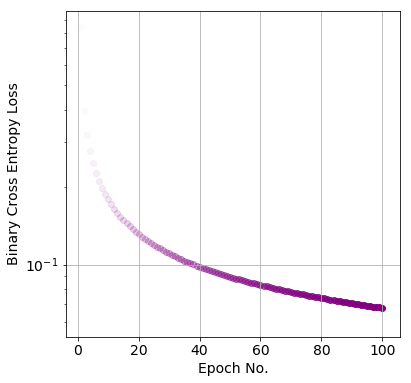

In [9]:
x_plot = [i+1 for i in range(len(loss_list))]
plt.figure(figsize=(6,6))
for ii in range(len(loss_list)):
    plt.scatter(x_plot[ii],loss_list[ii],color='purple',alpha=(ii+1)/len(x_plot))
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=14)
plt.xlabel("Epoch No.",fontsize=14)
plt.ylabel("Binary Cross Entropy Loss",fontsize=14)
plt.grid('on')
plt.savefig('ML_simple_log_reg_BCE_loss_curve.pdf')

Now we try to check if our derived output is the same as extracted from the model.

So, we are now clear about how weights/biases are imported to the function.<br>
Output = F.sigmoid(input * weight + bias) <br>
Next up, loss derivation:

In [10]:
# Load data to a Torch Variable
inputs = Variable(torch.from_numpy(y_tem_ori))         
               
# Forward pass only to get logits/output
outputs = model(inputs)

# Get predictions from the maximum value, though it's useless here
_, predicted = torch.max(outputs.data,1)

In [11]:
output_gen = []
tem = np.arange(start=-2.1,stop=4.9,step=0.02)
for ii in range(len(weight_list)):
    output_epoch = []
    for jj in range(len(inputs.numpy())):
        tem_output = sigmoid_output(inputs.numpy()[jj],weight_list[ii],bias_list[ii])
        output_epoch.append(tem_output)
    output_gen.append(output_epoch)

Now, the hardest part of the work, derivation.

/Users/tanghongming/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


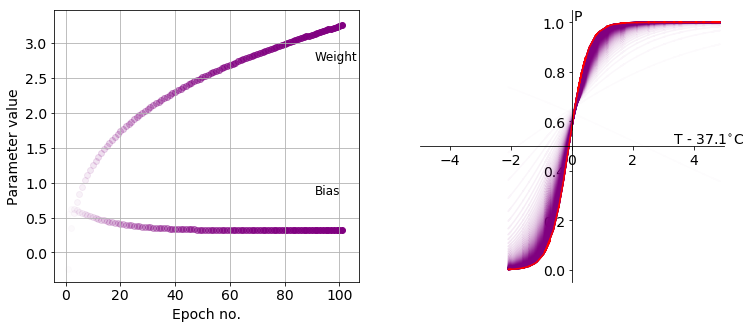

In [18]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,5))
# Fig.1
x_plot = [i+1 for i in range(len(weight_list))]
for ii in range(len(x_plot)):
    ax1.scatter(x_plot[ii],weight_list[ii],color='purple',alpha=((ii+1)/len(weight_list)))
    ax1.scatter(x_plot[ii],bias_list[ii],color='purple',alpha=((ii+1)/len(bias_list)))
ax1.text(max(x_plot)-10,max(weight_list)-0.5,'Weight',fontsize=12)
ax1.text(max(x_plot)-10,max(bias_list)+0.2,'Bias',fontsize=12)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.set_xlabel("Epoch no.",fontsize=14)
ax1.set_ylabel("Parameter value",fontsize=14)
ax1.grid('on')
# Fig.2
for ii in range(len(output_gen)):
    ax2.plot(inputs.numpy(),output_gen[ii],color='purple',alpha=(ii+1)/len(weight_list))
ax2.plot(inputs.numpy(),outputs.detach().numpy(),color='red')
ax2.set_xlabel("T - 37.1$^{\circ}$C",fontsize=14)
ax2.xaxis.set_label_coords(0.95, 0.55)
ax2.set_ylabel("P",fontsize=14,rotation=0)
ax2.yaxis.set_label_coords(0.52, 0.95)
ax2.set_xlim([-5,5])
ax2.tick_params(axis='both', which='major', labelsize=14)
# Move left y-axis and bottim x-axis to centre, passing through (0,0)
ax2.spines['left'].set_position('center')
ax2.spines['bottom'].set_position('center')

# Eliminate upper and right axes
ax2.spines['right'].set_color('none')
ax2.spines['top'].set_color('none')

# Show ticks in the left and lower axes only
ax2.xaxis.set_ticks_position('bottom')
ax2.yaxis.set_ticks_position('left')
plt.savefig("Thermometer_log_reg_learning_track.pdf")

In [13]:
inputs_test = inputs[s]
est_weight_grad,est_bias_grad = [],[]
for jj in range(len(weight_list)):
    weight_grad,bias_grad = derivative_chain_loss_gradient(inputs_test,labels.detach().numpy(),weight_list[jj],bias_list[jj])
    est_weight_grad.append(weight_grad.item())
    est_bias_grad.append(bias_grad.item())

Now we extract weight grad and bias grad from model

In [14]:
gradient_list_weight,gradient_list_bias = [],[]
for ii in range(len(weight_list)-1):
    tem_rate_weight = (weight_list[ii] - weight_list[ii+1])
    tem_rate_bias = (bias_list[ii] - bias_list[ii+1])
    gradient_list_weight.append(tem_rate_weight/learningRate)
    gradient_list_bias.append(tem_rate_bias/learningRate)

/Users/tanghongming/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


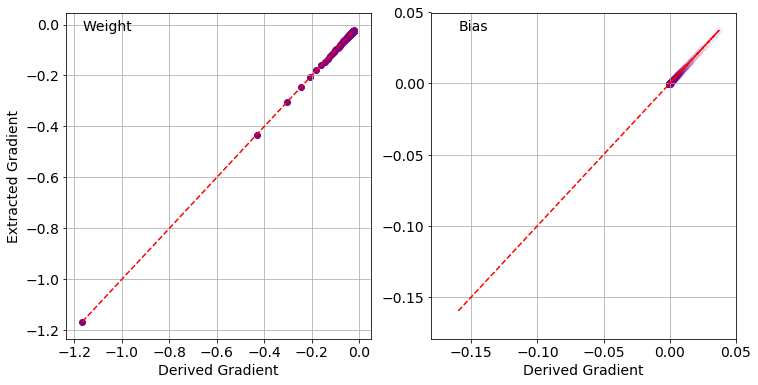

In [15]:
# select weight/bias grad estimation elements
est_bias_grad_plot = est_bias_grad[:-1]
est_weight_grad_plot = est_weight_grad[:-1]
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,6))

# Fig.1
for jj in range(len(gradient_list_weight)):
    ax1.scatter(est_weight_grad_plot[jj],gradient_list_weight[jj],color='purple',alpha=((ii)/len(gradient_list_weight)))
ax1.plot(gradient_list_weight,gradient_list_weight,'--',color='red')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.text(min(est_weight_grad_plot), max(est_weight_grad_plot),'Weight',fontsize=14)
ax1.set_xlabel('Derived Gradient',fontsize=14)
ax1.set_ylabel('Extracted Gradient',fontsize=14)
ax1.grid('on')
# Fig.2
for ii in range(len(gradient_list_bias)):
    ax2.scatter(est_bias_grad_plot[ii],gradient_list_bias[ii],color='purple',alpha=((ii)/len(gradient_list_bias)))
ax2.plot(est_bias_grad_plot,est_bias_grad_plot,'--',color='red')
ax2.tick_params(axis='both', which='major', labelsize=14)
ax2.text(min(est_bias_grad_plot), max(est_bias_grad_plot),'Bias',fontsize=14)
ax2.set_xlabel('Derived Gradient',fontsize=14)
ax2.grid('on')
plt.savefig("Thermometer_log_reg_loss_gradient_track.pdf")

Holly Molly. So here is thing: the difference between the derived weight gradient and the extracted one found before,<br>
is caused by using non-shuffled 'inputs' Variable in torch format when deriving the gradients. <br>
The offset gone when using the pre-defined **y_tem** or shuffled 'inputs'.